# Predictive Maintenance

In this notebook, we will explore various methods to handle the imbalance between the number of failures compared to non-failures.  In addition, we will attempt to fit various classification methods to the data in hopes of successsfully predicting a failure before it happens.

## Customize Enviornment

In [2]:
# load packages
packages <- c("purrr", "doMC", "RMySQL", "lubridate", "ggplot2", "caret", "DMwR", "pROC")
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

# set default plot size
options(repr.plot.width=10, repr.plot.height=6)

# configure multicore processing
registerDoMC(cores=8)

## Load Data

In [29]:
# create an open connection to the database
cn <- dbConnect(drv = RMySQL::MySQL(),
                host = "host",
                port = 3306,
                user = "user",
                password = "password",
                dbname = "db")

# query the database and store the results into a DataFrame
df <- dbGetQuery(cn, "SELECT * FROM dryer3_time_until_down")
dbDisconnect(cn)

[1] TRUE

In [30]:
# save df to local machine
saveRDS(df, "dryer3_time_until_down")
df <- readRDS("dryer3_time_until_down")

## Feature Engineering

In [31]:
# create new variables for dates and time
df$Datetime <- ymd_hms(df$Datetime)
df$YEAR <- year(df$Datetime)
df$MONTH <- month(df$Datetime)
df$WDAY <- wday(df$Datetime)
df$HOUR <- hour(df$Datetime)
df$MINUTE <- minute(df$Datetime)
df$Datetime <- NULL

In [32]:
head(df)

TIME_UNTIL_DOWN CircFan1 CircFan2 CircFan3 CircFan4 CircFan5 CircFan6
1 158             100      100      100      100      100      100     
2 156             100      100      100      100      100      100     
3 154             100      100      100      100      100      100     
4 152             100      100      100      100      100      100     
5 150             100      100      100      100      100      100     
6 148             100      100      100      100      100      100     
  CircFanAct1 CircFanAct2 CircFanAct3 ⋯ Valve2 Valve3 Valve4 Valve5 Valve6 YEAR
1 600         600         600         ⋯ 100    100    100    100    100    2015
2 600         600         600         ⋯ 100    100    100    100    100    2015
3 600         600         600         ⋯ 100    100    100    100    100    2015
4 600         600         600         ⋯ 100    100    100    100    100    2015
5 600         600         600         ⋯ 100    100    100    100    100    2015
6 600         600         600         ⋯ 100    100    100    100    100    2015
  MONTH WDAY HOUR MINUTE
1 1     5    0     0    
2 1     5    0     2    
3 1     5    0     4    
4 1     5    0     6    
5 1     5    0     8    
6 1     5    0    10

## Partition Data

#### Because this is time-series data, we cannot partition our dataset using a random sample approach.  Instead, we will divide the data by putting the first 9 months into the training data, and the remaining 2 months into the test dataset.

In [35]:
# split into training and test
df2015 = df[df$YEAR == 2015, ]
train <- df2015[df2015$MONTH <= 1, ]
test <- df2015[df2015$MONTH > 9, ]

In [36]:
# compare number of records in training and test
cat("Number of records in training:")
nrow(train)

cat("\nNumber of records in test:")
nrow(test)

Number of records in training:

[1] 21329


Number of records in test:

[1] 46942

## Predict Time Until Down Event

In [37]:
lm_fit <- train(TIME_UNTIL_DOWN ~ ., 
                data = train, 
                method = "lm",
                na.action = na.exclude)

In [38]:
summary(lm_fit)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-348.11 -102.03  -24.32   78.04  529.53 

Coefficients: (25 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -6.836e+03  2.363e+03  -2.893 0.003815 ** 
CircFan1                NA         NA      NA       NA    
CircFan2                NA         NA      NA       NA    
CircFan3                NA         NA      NA       NA    
CircFan4                NA         NA      NA       NA    
CircFan5                NA         NA      NA       NA    
CircFan6                NA         NA      NA       NA    
CircFanAct1     -3.782e-01  1.248e-01  -3.031 0.002441 ** 
CircFanAct2      1.507e-01  1.571e-01   0.960 0.337291    
CircFanAct3     -6.787e-02  1.488e-01  -0.456 0.648399    
CircFanAct5      1.292e-01  1.194e-01   1.082 0.279204    
CircFanAct6     -2.878e-01  8.480e-02  -3.394 0.000691 ***
CircfanAct4      3.149e-02  1.678e-0

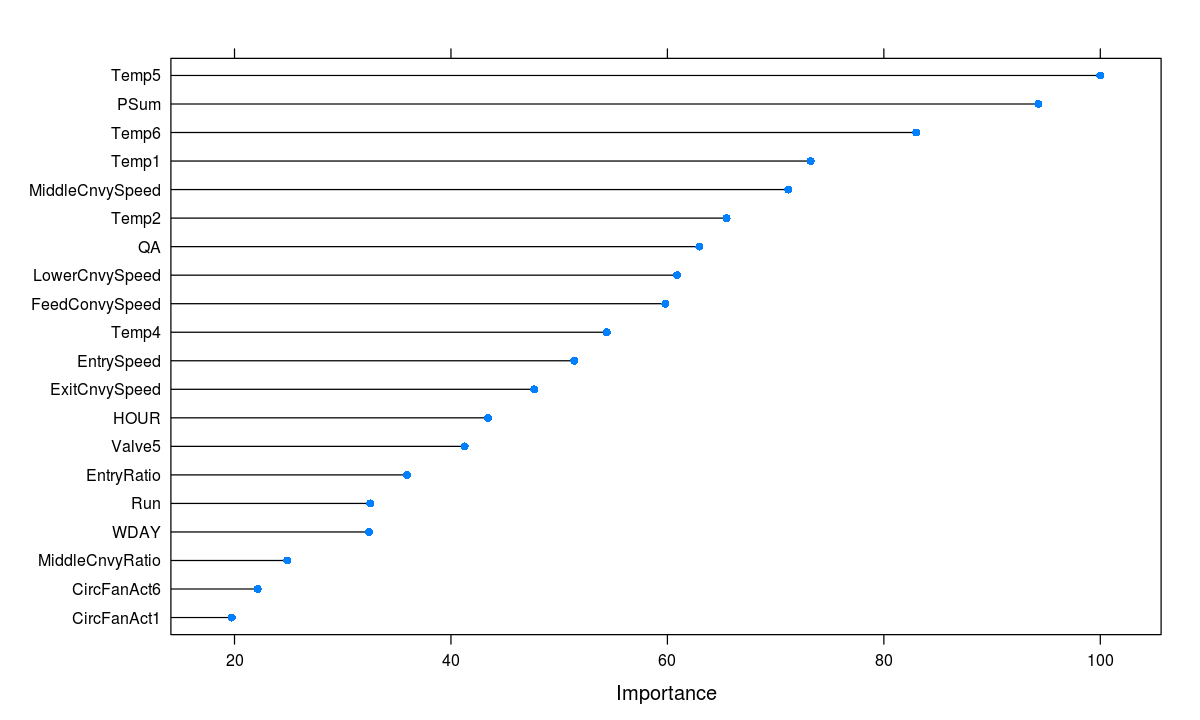

In [39]:
plot(varImp(lm_fit), top = 20)

In [42]:
ctree_fit <- train(TIME_UNTIL_DOWN ~ ., 
                   data = train,
                   method = 'ctree',
                   tuneGrid=expand.grid(mincriterion=0.95), 
                   na.action = na.exclude)

In [44]:
summary(ctree_fit)

    Length      Class       Mode 
         1 BinaryTree         S4 

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to max; returning -Inf”Warning message in FU

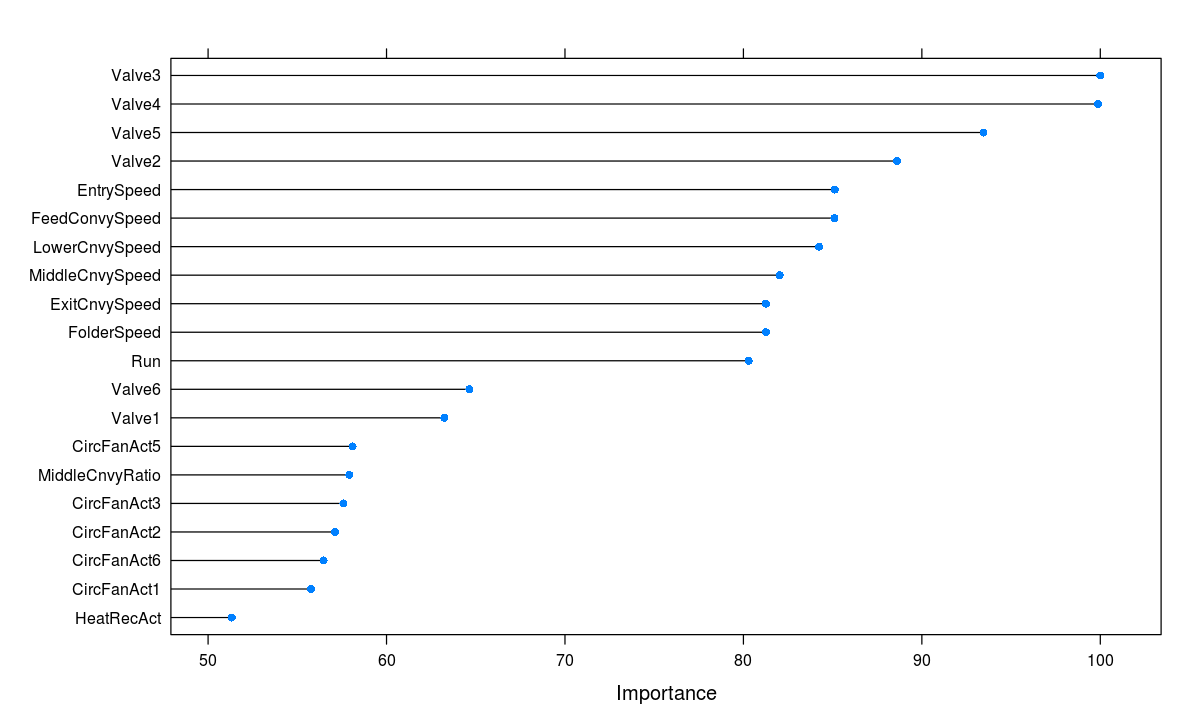

In [43]:
plot(varImp(ctree_fit), top = 20)

In [45]:
rpart_fit <- train(TIME_UNTIL_DOWN ~ ., 
                   data = train, 
                   method = 'rpart', 
                   metric='RMSE',
                   na.action = na.exclude)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

In [46]:
summary(rpart_fit)

Call:
rpart(formula = .outcome ~ ., data = list(CircFan1 = c(100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 
100,

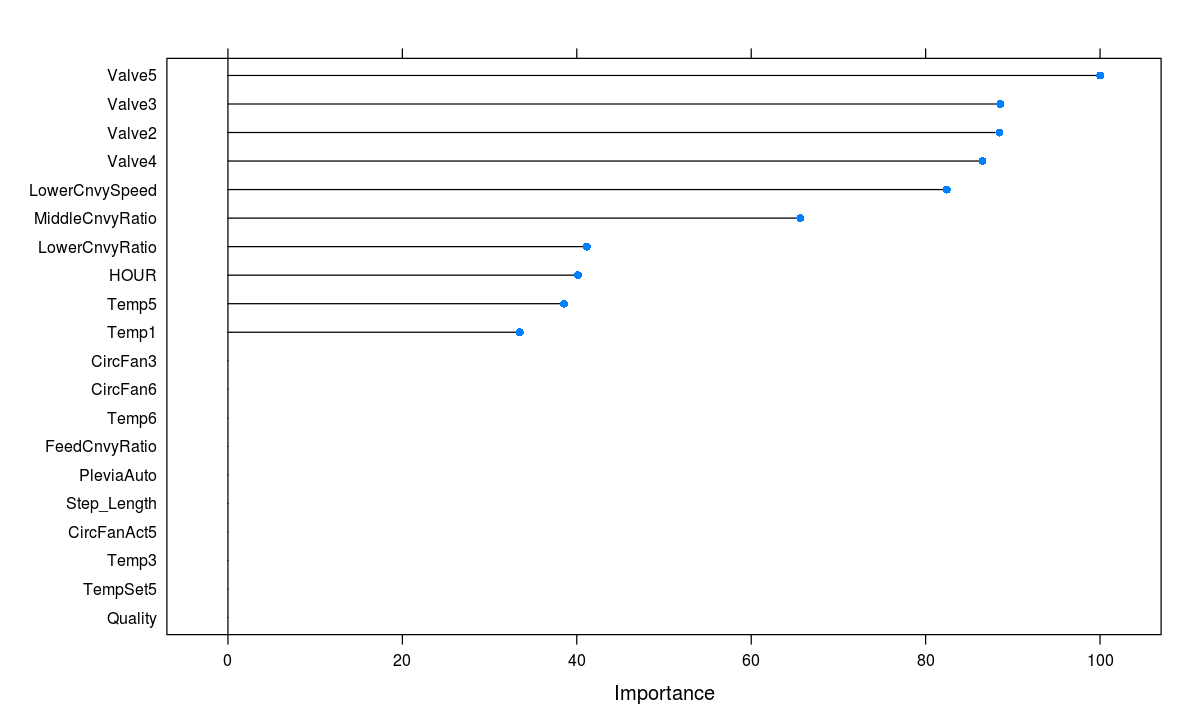

In [47]:
plot(varImp(rpart_fit), top = 20)

In [ ]:
3;